In [1]:
# Import required libraries
import matplotlib.pyplot as plt
from kika.cov.parse_covmat import read_njoy_covmat
from kika.plotting import PlotBuilder

# Path to GENDF file
gendf = '/home/MONLEON-JUAN/KIKA/kika/cov/files/260560_80.06.xs.gendf'

In [2]:
# Parse the GENDF file to get CovMat object
covmat = read_njoy_covmat(gendf)
print(f"Number of energy groups: {covmat.num_groups}")
print(f"Number of matrices: {covmat.num_matrices}")

Number of energy groups: 56
Number of matrices: 7


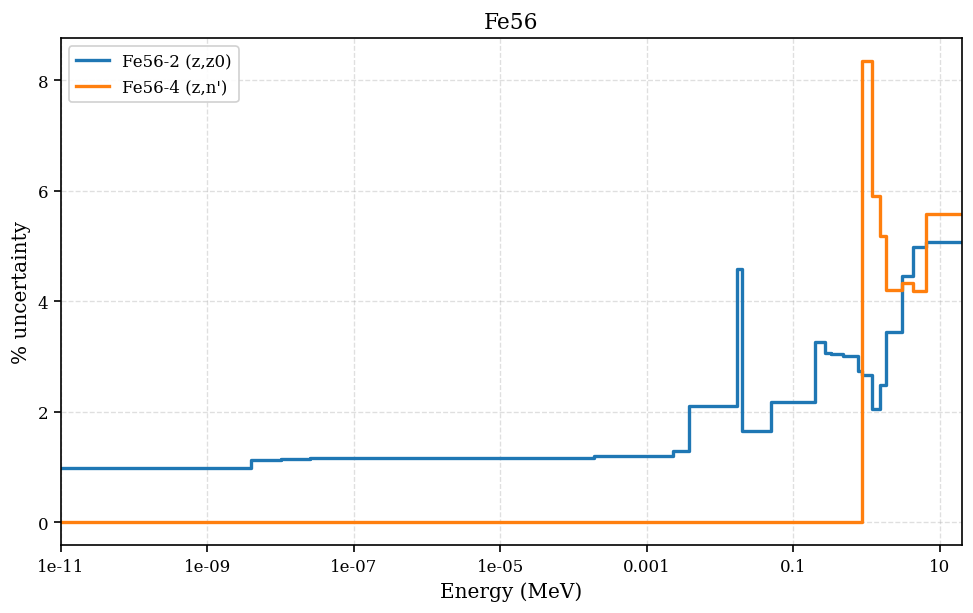

In [3]:
# OLD plot system of uncertainties from CovMat
fig, ax = plt.subplots(figsize=(10, 6))
covmat.plot_uncertainties(zaid=26056, mt=[2,4]);

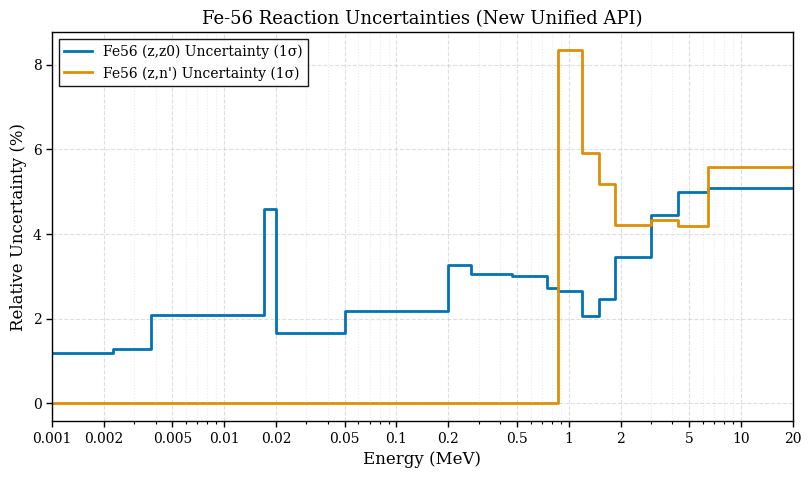

In [4]:
# NEW plot system of uncertainties from CovMat
nom_data_2, unc_data_2 = covmat.to_plot_data(zaid=26056, mt=2)
nom_data_4, unc_data_4 = covmat.to_plot_data(zaid=26056, mt=4)

fig_unc_new = (PlotBuilder(style='paper', figsize=(12, 7))
                    .add_data(unc_data_2)  
                    .add_data(unc_data_4) 
                    .set_labels(
                        title='Fe-56 Reaction Uncertainties (New Unified API)',
                        x_label='Energy (MeV)',
                        y_label='Relative Uncertainty (%)'
                    )
                    .set_scales(log_x=True)
                    .set_limits(x_lim=(1e-3, 20))
                    .build())

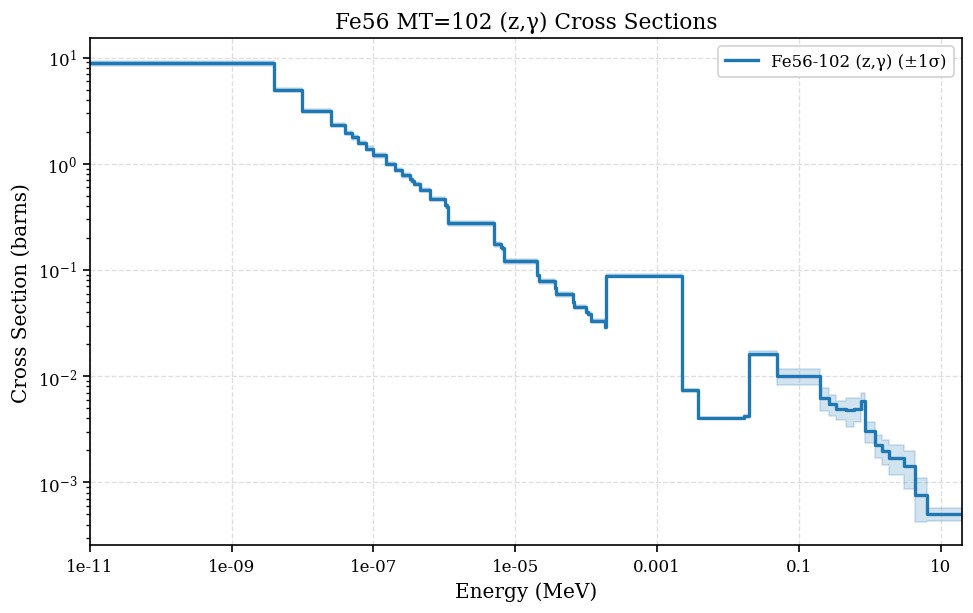

In [5]:
# OLD plot system of multigroup cross-sections with uncertainties
covmat.plot_multigroup_xs(zaid=26056, mt=[102], show_uncertainties=True, sigma=1.0);

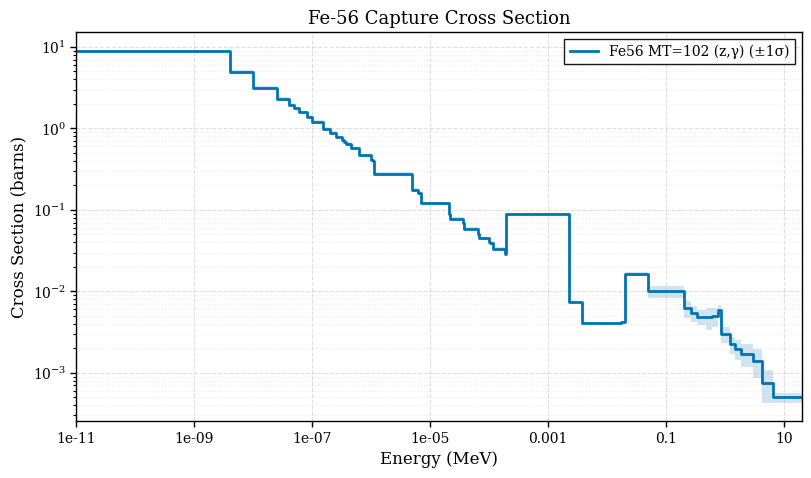

In [6]:
# NEW plot system of multigroup cross-sections with uncertainties
xs_data, unc_band = covmat.to_plot_data(zaid=26056, mt=102)

fig_xs_no_unc = (PlotBuilder(style='paper', figsize=(12, 7))
                       .add_data(xs_data, uncertainty=unc_band) 
                       .set_labels(
                           title='Fe-56 Capture Cross Section',
                           x_label='Energy (MeV)',
                           y_label='Cross Section (barns)'
                       )
                       .set_scales(log_x=True, log_y=True)
                       .build())

/home/MONLEON-JUAN/KIKA/kika/plotting/plot_builder.py:625: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  self.ax.set_ylim(y_min, y_max)


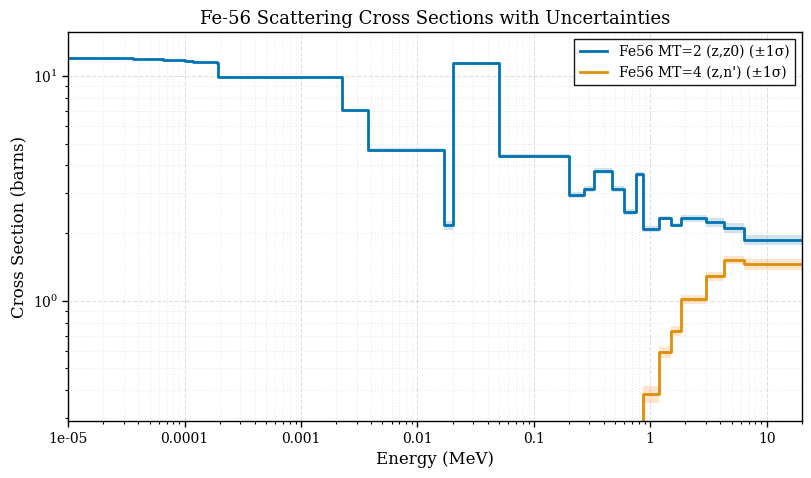

In [7]:
# Test 4: Compare multiple reactions with uncertainties
xs_elastic, unc_elastic = covmat.to_plot_data(26056, 2)
xs_inelastic, unc_inelastic = covmat.to_plot_data(26056, 4)

fig_comparison = (PlotBuilder(style='paper', figsize=(12, 7))
                       .add_data(xs_elastic, uncertainty=unc_elastic)
                       .add_data(xs_inelastic, uncertainty=unc_inelastic)
                       .set_labels(
                           title='Fe-56 Scattering Cross Sections with Uncertainties',
                           x_label='Energy (MeV)',
                           y_label='Cross Section (barns)'
                       )
                       .set_scales(log_x=True, log_y=True)
                       .set_limits(x_lim=(1e-5, 20))
                       .build())

## ✅ Fixed: Step Plot Vertical Line Issue

**Problem**: The NEW plotting system was showing a vertical line at the end of uncertainty plots.

**Root Cause**: Step plots with `where='post'` require **G+1 points** (energy bin edges) for both x and y arrays to properly display G energy groups. The old system was correctly using G+1 points, but the new system was only using G points (group centers).

**Solution**: Modified `CovMat.to_plot_data()` to:
1. Use energy bin edges (G+1 points) instead of group centers (G points) for x-axis
2. Extend y-values from G to G+1 by repeating the last value: `y = np.r_[values, values[-1]]`
3. This matches the OLD plotting system behavior in `plot_uncertainties()`

**Result**: Step plots now correctly extend to the right edge with horizontal steps, no vertical lines! ✅

In [8]:
from kika.cov.multigroup.plotting_mg import (
    plot_mg_legendre_coefficients, 
    plot_mg_vs_endf_comparison)
from kika.cov.multigroup import plotting_mg
from kika.energy_grids import SCALE56
from kika.cov.multigroup.MF34_to_MG import MF34_to_MG
from kika.energy_grids import SCALE56

from kika.endf.read_endf import read_endf

In [9]:
# Load the same ENDF file used in test_mf34cov.ipynb
jeff_Fe56 = '/share_snc/snc/JuanMonleon/jeff40_with_MF4_from_jeff33/26-Fe-56g.txt'
jeff_endf = read_endf(jeff_Fe56)
SCALE56_eV = [e * 1e6 for e in SCALE56] 

/home/MONLEON-JUAN/KIKA/kika/endf/parsers/parse_endf.py:90: UserWarning: Skipping MF sections without parsers: [2, 3, 6, 8, 10, 12, 14, 33]. Only parsing: [1, 4, 34]
  warnings.warn(f"Skipping MF sections without parsers: {skipped_mfs}. Only parsing: {parseable_mfs}")


In [10]:
mg_cov = MF34_to_MG(
    endf_object=jeff_endf,
    energy_grid=SCALE56_eV,
    weighting_function="constant",
    isotope=26056,  
    mt=2
)

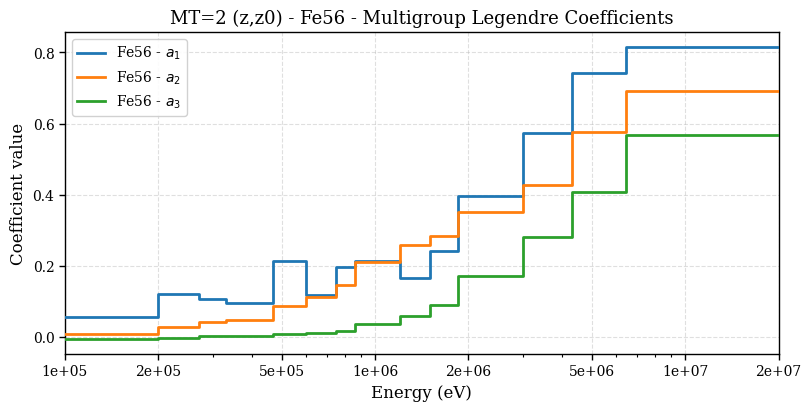

In [11]:
# OLD plot system of multigroup Legendre coefficients with uncertainties
fig = plot_mg_legendre_coefficients(
    mg_covmat=mg_cov,
    isotope=26056,
    mt=2,
    orders=[1,2,3],
    energy_range=(1e5, 2e7),
    figsize=(12, 6),
    include_uncertainties=True,
    marker=False
)

✓ Successfully plotted multigroup Legendre coefficients with uncertainties using PlotBuilder


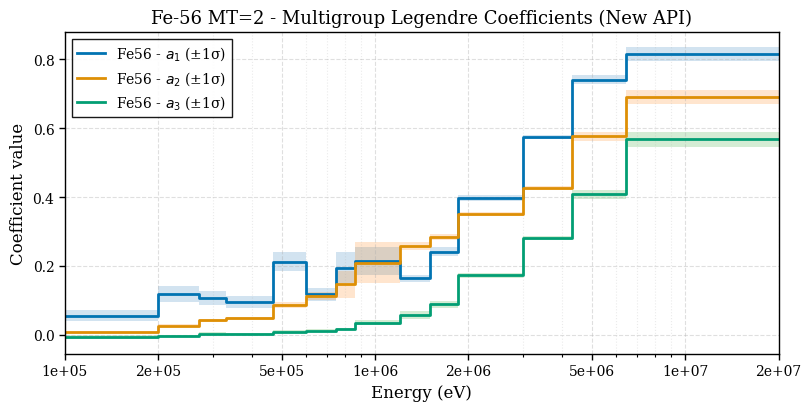

In [12]:
# NEW plotting system for multigroup Legendre coefficients with uncertainties
legendre_L1, unc_L1 = mg_cov.to_plot_data(isotope=26056, mt=2, order=1)
legendre_L2, unc_L2 = mg_cov.to_plot_data(isotope=26056, mt=2, order=2)
legendre_L3, unc_L3 = mg_cov.to_plot_data(isotope=26056, mt=2, order=3)

fig_mg_new = (PlotBuilder(style='paper', figsize=(12, 6))
               .add_data(legendre_L1, uncertainty=unc_L1)
               .add_data(legendre_L2, uncertainty=unc_L2)
               .add_data(legendre_L3, uncertainty=unc_L3)
               .set_labels(
                   title='Fe-56 MT=2 - Multigroup Legendre Coefficients (New API)',
                   x_label='Energy (eV)',
                   y_label='Coefficient value'
               )
               .set_scales(log_x=True)
               .set_limits(x_lim=(1e5, 2e7))
               .build())

print("✓ Successfully plotted multigroup Legendre coefficients with uncertainties using PlotBuilder")

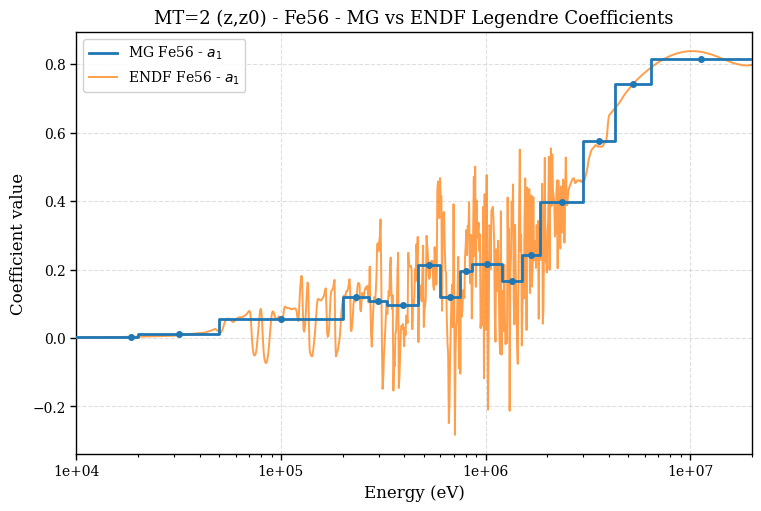

In [13]:
# OLD plot system of multigroup cross-sections vs ENDF with uncertainties
fig = mg_cov.plot_vs_endf(
    endf=jeff_endf,
    isotope=26056,
    mt=2,
    orders=[1],  # Just L=1 for cleaner visualization
    energy_range=(1e4, 2e7),  # Zoom in on interesting range
    #figsize=(12, 6),
    include_uncertainties=True,
)

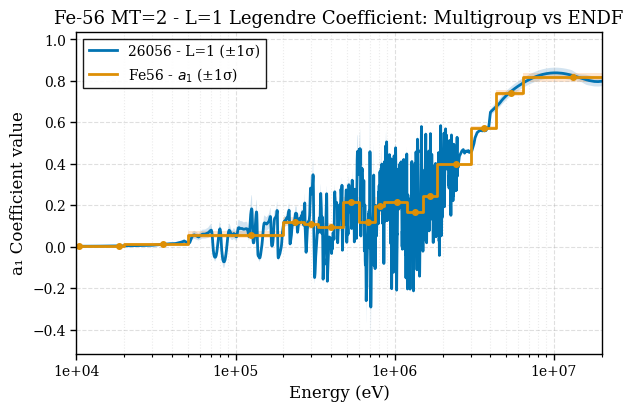

In [14]:
# NEW plotting system for multigroup vs ENDF Legendre coefficients with uncertainties
mg_legendre_L1, mg_unc_L1 = mg_cov.to_plot_data(isotope=26056, mt=2, order=1)

# Get fresh ENDF data
endf_legendre_L1, endf_unc_L1 = jeff_endf.to_plot_data(mf=4, mt=2, order=1)

fig_comparison = (PlotBuilder(style='paper', figsize=(6, 4))
                   .add_data(endf_legendre_L1, uncertainty=endf_unc_L1) 
                   .add_data(mg_legendre_L1, uncertainty=mg_unc_L1, marker='o', markersize=4) 
                   .set_labels(
                       title='Fe-56 MT=2 - L=1 Legendre Coefficient: Multigroup vs ENDF',
                       x_label='Energy (eV)',
                       y_label='a₁ Coefficient value'
                   )
                   .set_scales(log_x=True)
                   .set_limits(x_lim=(1e4, 2e7))
                   .set_tick_params(max_ticks_x=5)
                   .build())

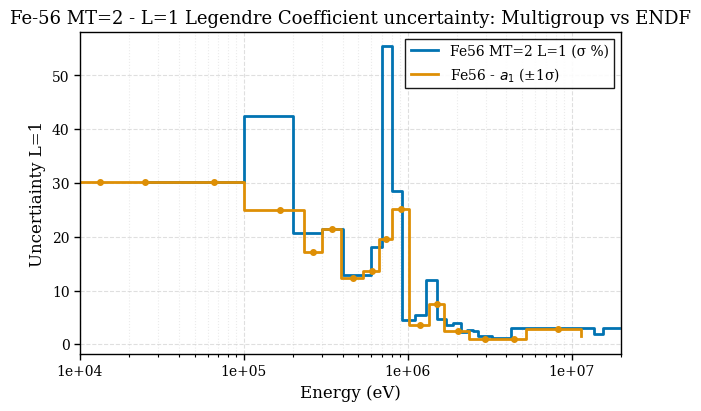

In [15]:
# NEW plotting system for multigroup vs ENDF Legendre uncertainties
mg_legendre_L1, mg_unc_L1 = mg_cov.to_plot_data(isotope=26056, mt=2, order=1)

# Get fresh ENDF data
endf_legendre_L1, endf_unc_L1 = jeff_endf.to_plot_data(mf=4, mt=2, order=1)

fig_comparison = (PlotBuilder(style='paper', figsize=(6, 4))
                   .add_data(endf_unc_L1,) 
                   .add_data(mg_unc_L1, marker='o', markersize=4) 
                   .set_labels(
                       title='Fe-56 MT=2 - L=1 Legendre Coefficient uncertainty: Multigroup vs ENDF',
                       x_label='Energy (eV)',
                       y_label='Uncertiainty L=1'
                   )
                   .set_scales(log_x=True)
                   .set_limits(x_lim=(1e4, 2e7))
                   .set_tick_params(max_ticks_x=5)
                   .build())